In [23]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vread
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [121]:
# take largest isodata image region, and return aclassification
def sideify(cons_of_max, lens):    
    if cons_of_max == 3 and lens < 115 and lens > 98:
        return "c"
    elif cons_of_max == 2 and lens < 95 and lens > 80:
        return "t"
    else:
        return "ucf"
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    length = 0
    dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vd = vector_dist(cv, cv2)
        length += vd
        if vd <= 2*radius: # blob centers closer than diameter of one blob
            num_connections += 1
        else:
            pass
        dists.append(vd/(2*radius))
    return (num_connections, dists, length)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [43]:
connect_test = connect((0, 0),2, [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

2 [5.0, 10.0] hello


In [119]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    max_rad = 15*1.35
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        highlight = morphology.erosion(morphology.opening(thresh_img, square(7)),
                                        square(2))
        img = np.copy(frame)
        img[highlight==0] = 0
        blobs =skimage.feature.blob_doh(img, min_sigma = 6, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.75)
        blobset.append(blobs)
        
        num_connections = 0
        
        blobs = sorted(blobs, key = third_item, reverse=True)
        num_blobs = len(blobs)
        max_blob = blobs[0]
        connect_dists =connect((max_blob[1],max_blob[0]),max_rad, blobs[1::])
        cons_of_max = connect_dists[0]
        num_connections +=cons_of_max 
        distances = connect_dists[1]
        length_of_transparents=0
        num_smaller_blobs = num_blobs - 1
        for i in range(num_smaller_blobs-1):
            blob = blobs[i+1]
            center_vec = (blob[1], blob[0])
            connect_dists = connect(center_vec, max_rad, blobs[i+2::])
            num_connections += connect_dists[0]
            length_of_transparents += connect_dists[2]
            distances.extend(connect_dists[1])
        #----------------------filter------------------------- can use actual filter
        properties = [num_blobs, num_connections, cons_of_max, length_of_transparents, distances]
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = (num_blobs == expected_blobs
                and num_connections == expected_connections 
               )
        if test:  
            if (cons_of_max == 3 or cons_of_max == 2):
                #-----------------------------classify pt 1---------------------------------------
                clas = sideify(cons_of_max, length_of_transparents )
                filtrate_prop.append(properties)
            else:
                clas = 'ucf'
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






[[6, 8, 9]]

In [29]:
filenames = filename = glob("./tchakamau/trn*/*[1][0]v*[0,6,2].avi")#glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 4
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"t" : list(range(37949, 30697, -25)),
                  "c" :list(range(20951, 20172, -3)), 
                 "broken" :list(range(21927, 21593, -1)) ,
                 "odd_s" :list(range(21593,21577, -1)) }
phantom_frames_2 = {"t" : list(range(26391, 22129, -25)),
                  "c" :list(range(21152, 20607, -1 )), 
                 "broken" :list(range(21979, 21309, -2)) ,
                 "odd_s" :list(chain(range(22115, 22080, -1), range(22017,21980, -1), range(21302, 21272, -1))) }
phantom_frames_3 = {"t" :list(range(30104, 29591, -1)),
                  "c" :list(range(30816, 30375, -2)), 
                 "broken" :list(range(30340, 30288, -1)) ,
                 "odd_s" :[]}
phantom_frame_sets = [phantom_frames,phantom_frames_2,phantom_frames_3]
trigger_frames = [37949, 26391,30816]#[13268, 18192, 2964, 8535]


['./tchakamau\\Trnansparentd\\45400_10Vpp_0.avi', './tchakamau\\Trnansparentd\\45403_10Vpp_6.avi', './tchakamau\\Trnansparentd\\45405_10Vpp_2.avi']


In [30]:
t_frames = []
tvals  = []
c_frames = []
cvals = []

odd_s_frames = []
oddsvals = []
broken_frames = []
brokenvals = []


framesets = [t_frames, c_frames,  odd_s_frames, 
             broken_frames]
frametypevals = [tvals, cvals,  oddsvals, brokenvals]
framesetnames = ["t", "c", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []
    
for vidnum in range(len(filenames)):
    frames = vread(filenames[vidnum])
    frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(len(frame_vid))
    
    
    for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        frametypevals[i].extend(typevals)
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])


37950
22303
26935


In [122]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[2])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(frametypevals[i])
    fil = len(x[1])
    print(orig, len(filtrates_props[i]), len(x[1]))
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", fil*100/orig)
        p_rats.append(fil*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

975 955 952
t _vid
original_vid:  975
filtrate:  952
pass ratio:  97.64102564102564


1026 918 912
c _vid
original_vid:  1026
filtrate:  912
pass ratio:  88.88888888888889


118 25 106
odd_s _vid
original_vid:  118
filtrate:  106
pass ratio:  89.83050847457628


721 5 721
broken _vid
original_vid:  721
filtrate:  721
pass ratio:  100.0


4 4 4


num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
t : 5 
c : 5 
odd_s : 4 
broken : 2 
num_connections variances: 
t : 0 
c : 1 
odd_s : 1 
broken : 1 
cons_of_max averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
cons_of_max variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 0 
length_of_transparents averages: 
t : 87 
c : 102 
odd_s : 96 
broken : 175 
length_of_transparents variances: 
t : 65 
c : 502 
odd_s : 1795 
broken : 9854 
975
5796
distances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 2 
distances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 


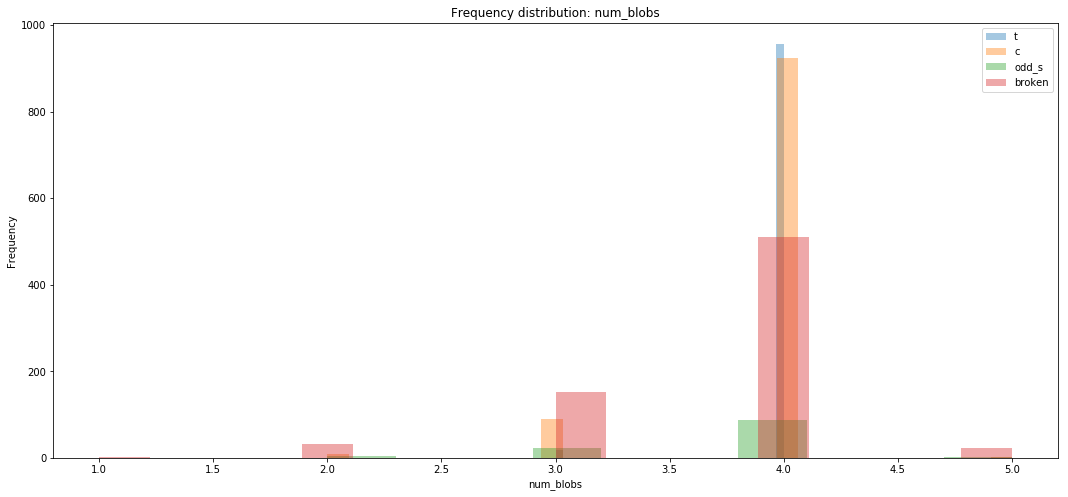

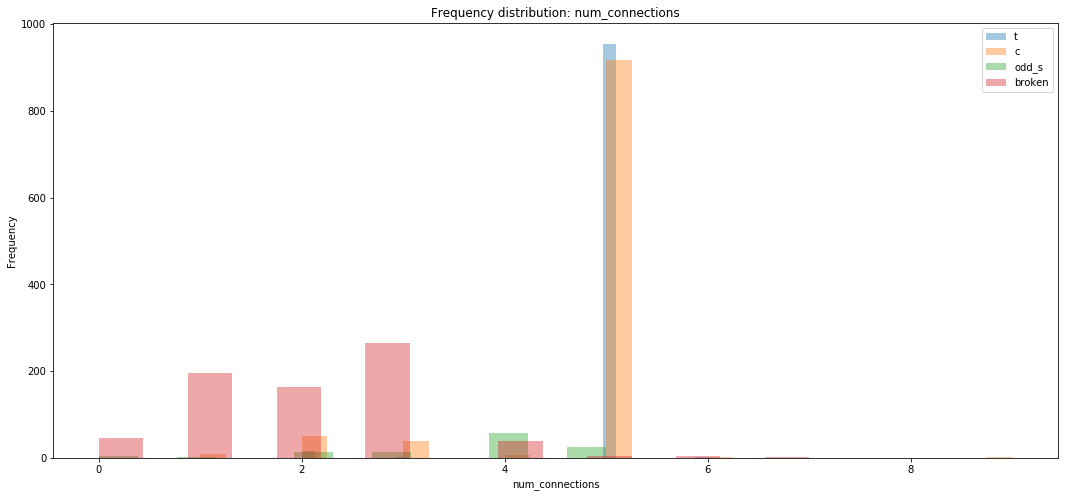

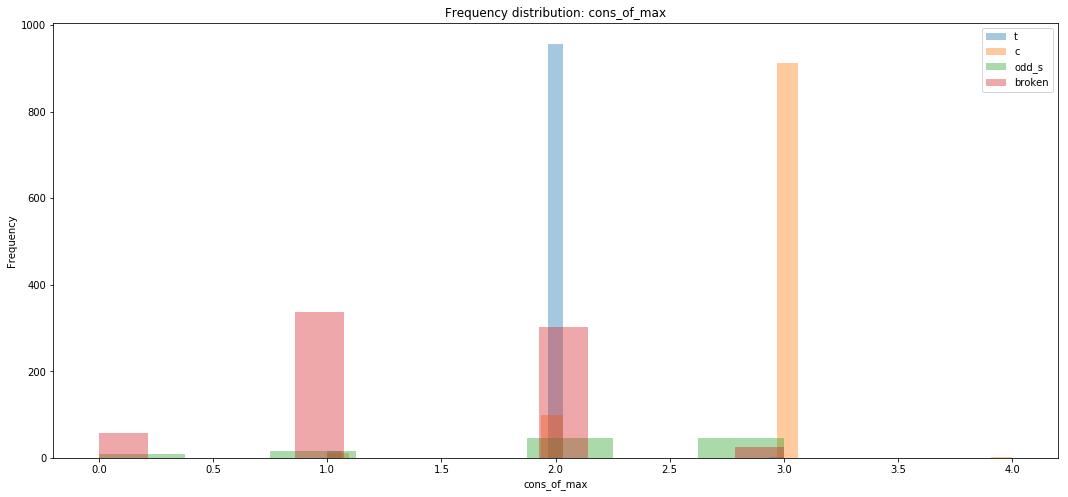

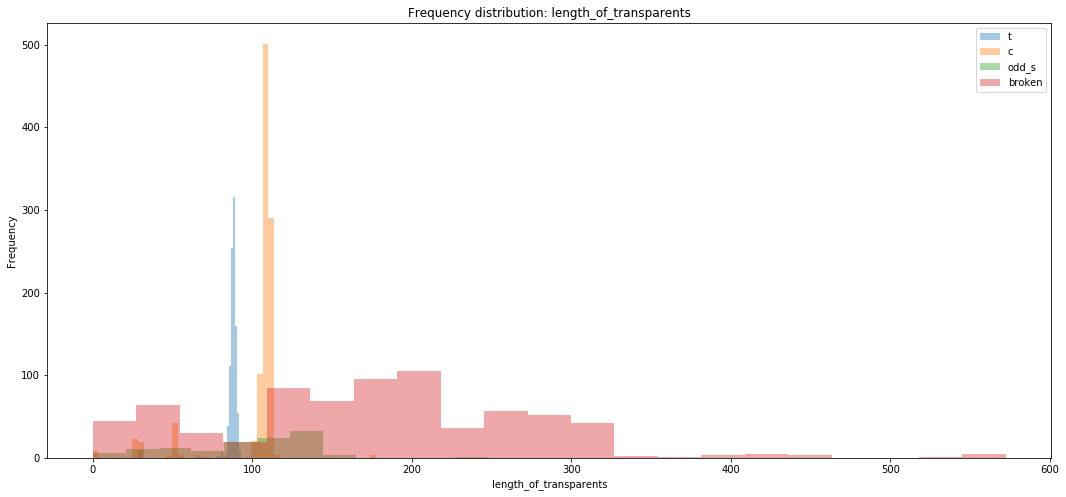

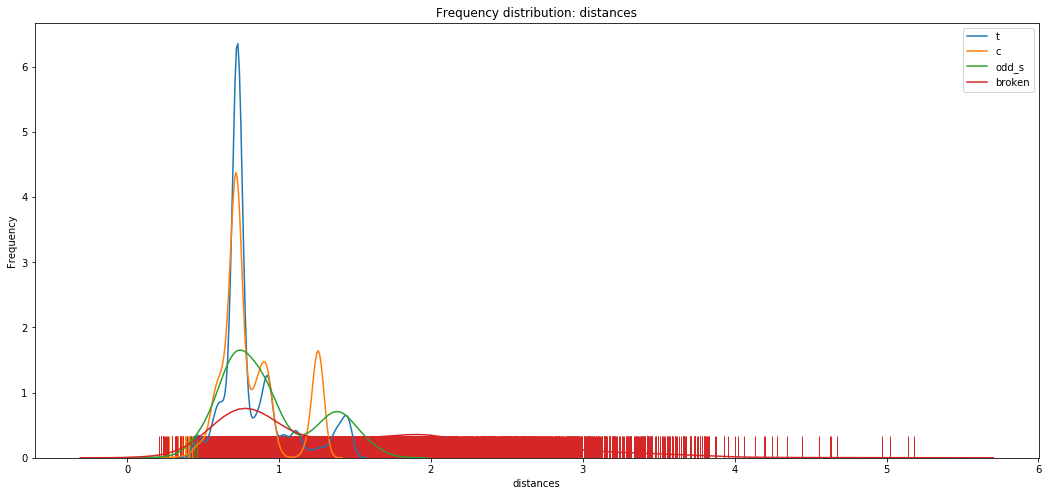

In [125]:
"""FINDING CORRECT THRESHOLDS FOR SEPARATING BROKEN AND ODD SHAPED FRAMES"""

# use area information from properties


propnames = ['num_blobs', 'num_connections', 'cons_of_max', 'length_of_transparents']
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [h[k] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
klist = []
for i in range(num_shape_cats):
    x = [d for lis in [h[4] for h in a_props[i]] for d in lis]
    klist.append(x) #list of areas for every category
print(len(klist[0]))
print("distances averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
print("distances variances: " )
[print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: " +  'distances')
plt.xlabel( 'distances')
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = klist[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
t : 5 
c : 5 
odd_s : 5 
broken : 5 
num_connections variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
cons_of_max averages: 
t : 2 
c : 3 
odd_s : 3 
broken : 3 
cons_of_max variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
length_of_transparents averages: 
t : 88 
c : 109 
odd_s : 105 
broken : 111 
length_of_transparents variances: 
t : 3 
c : 15 
odd_s : 311 
broken : 354 
955
5730
distances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
distances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 


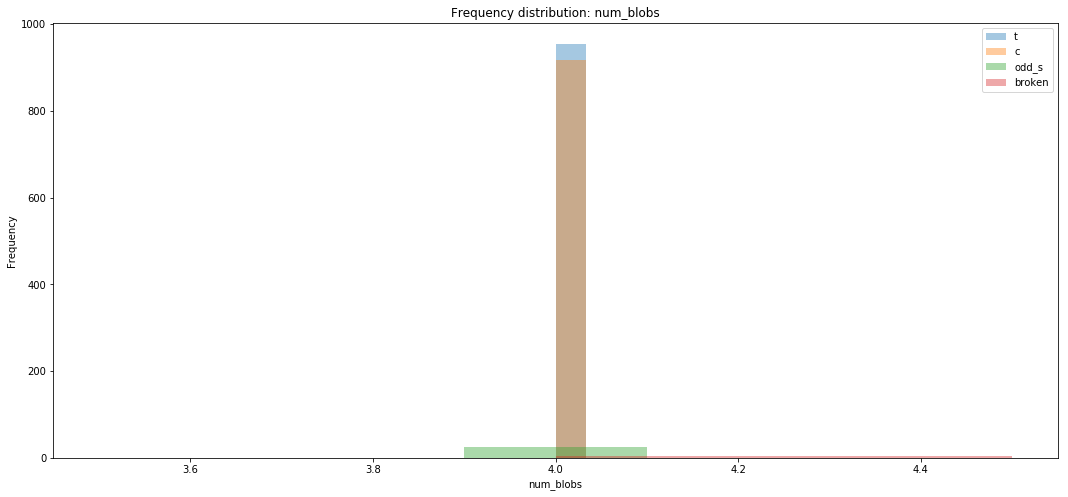

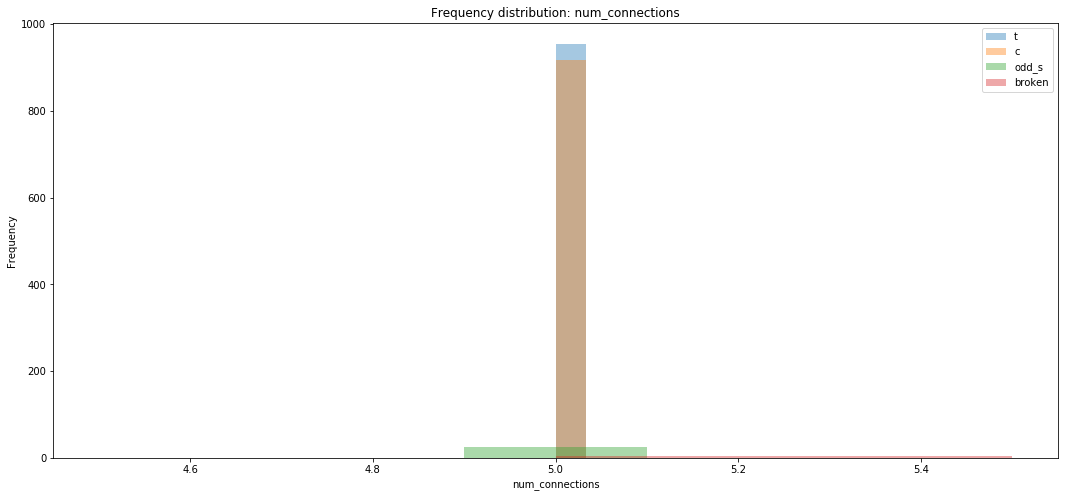

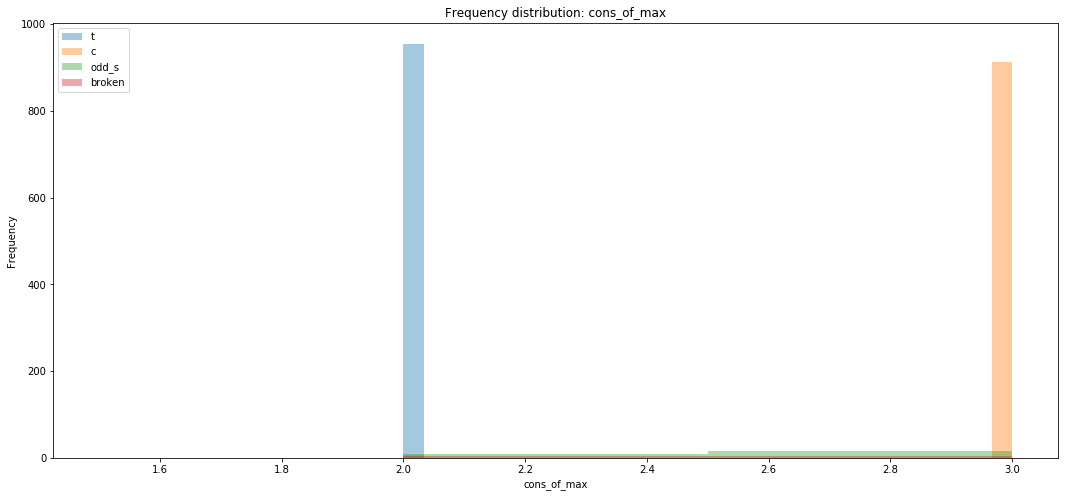

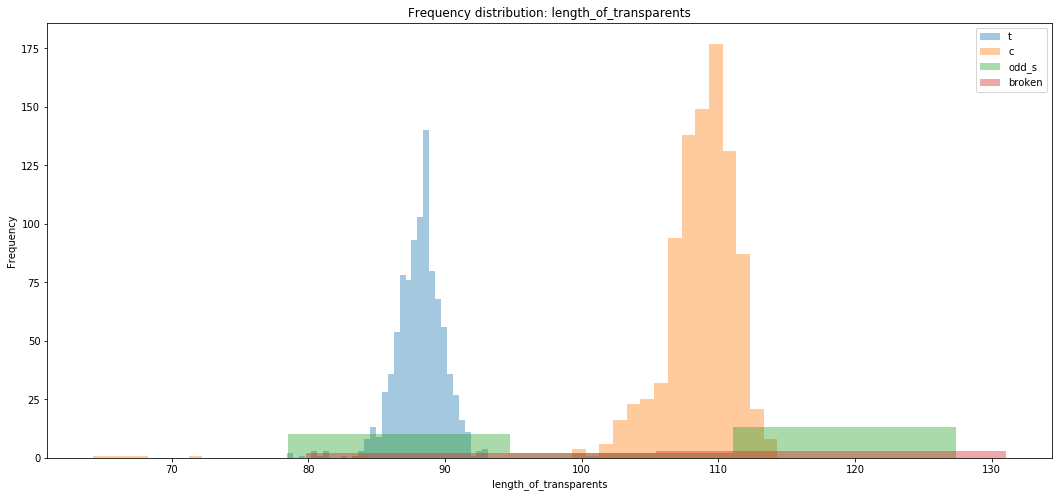

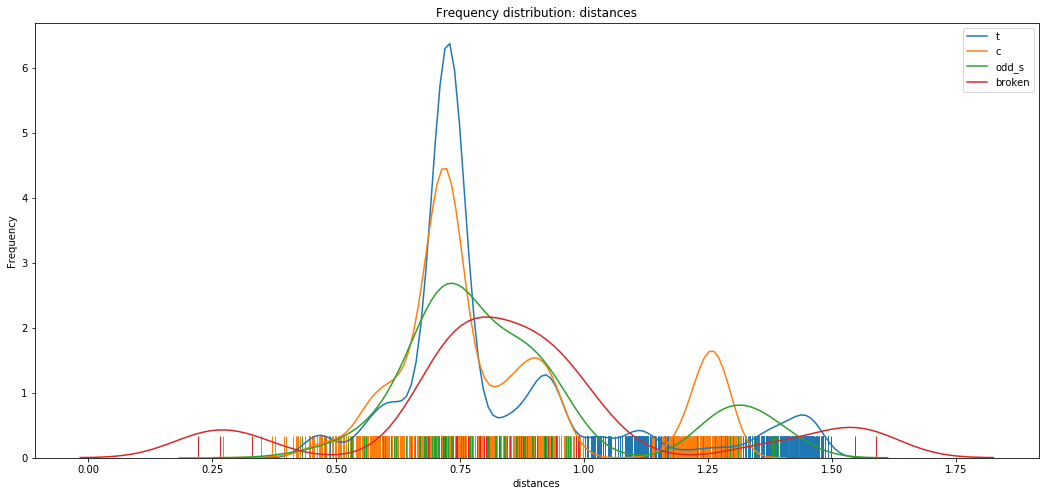

In [126]:
"""After first tests"""
# use area information from properties


propnames = ['num_blobs', 'num_connections', 'cons_of_max', 'length_of_transparents']
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [h[k] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
print(len(klist[0]))
klist = []
for i in range(num_shape_cats):
    x = [d for lis in [h[4] for h in filtrates_props[i]] for d in lis]
    klist.append(x) #list of areas for every category
print(len(klist[0]))
print("distances averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
print("distances variances: " )
[print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: " +  'distances')
plt.xlabel( 'distances')
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = klist[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
t : 5 
c : 5 
odd_s : 4 
broken : 2 
num_connections variances: 
t : 0 
c : 1 
odd_s : 1 
broken : 1 
cons_of_max averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
cons_of_max variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 0 
length_of_transparents averages: 
t : 87 
c : 102 
odd_s : 96 
broken : 175 
length_of_transparents variances: 
t : 65 
c : 502 
odd_s : 1795 
broken : 9854 
975
5796
distances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 2 
distances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 


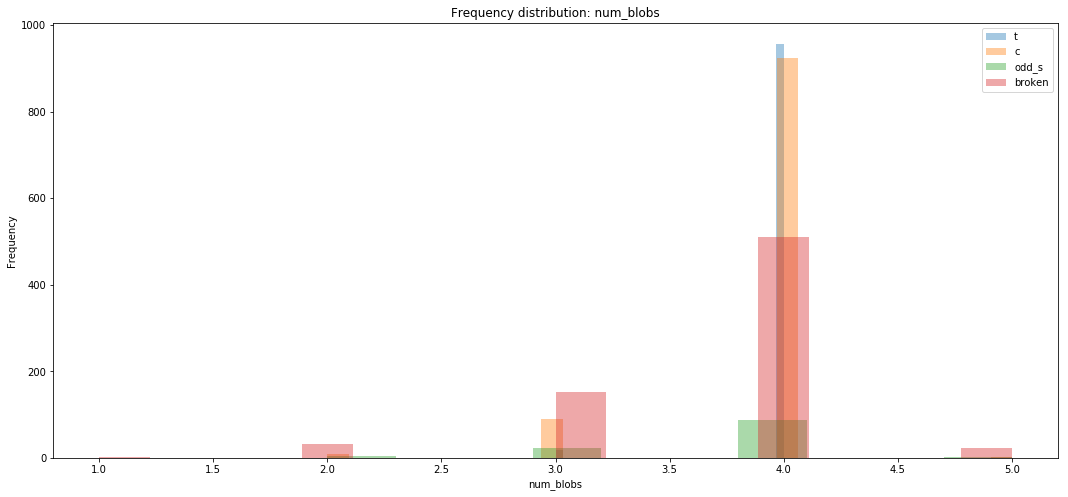

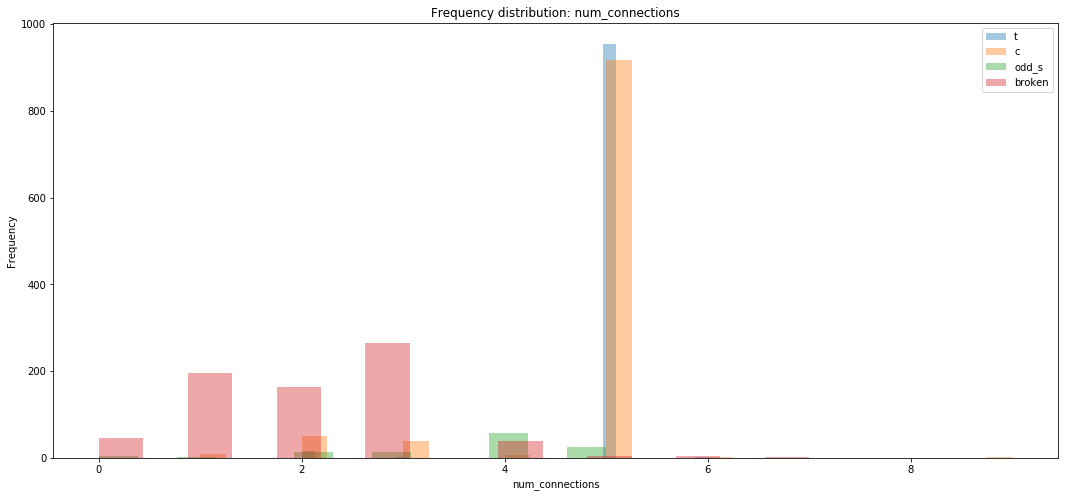

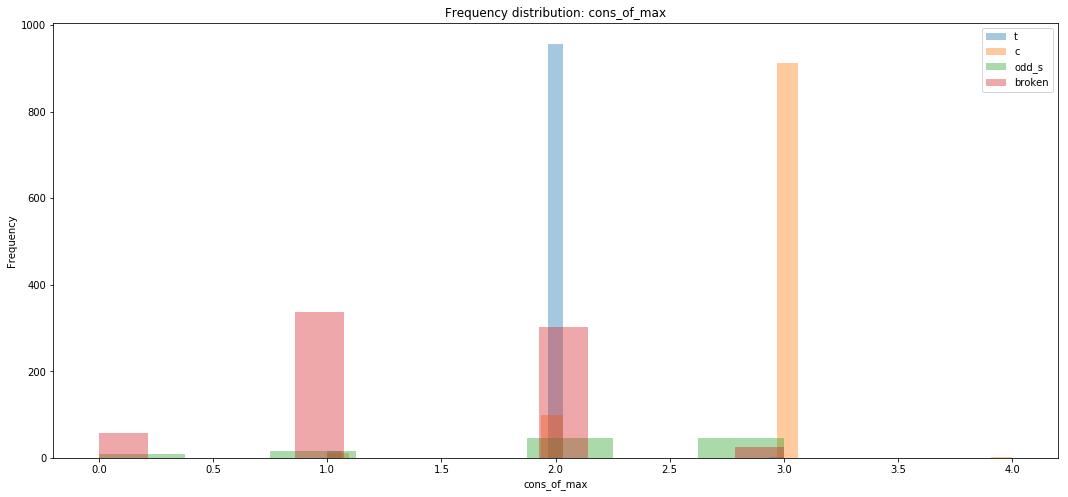

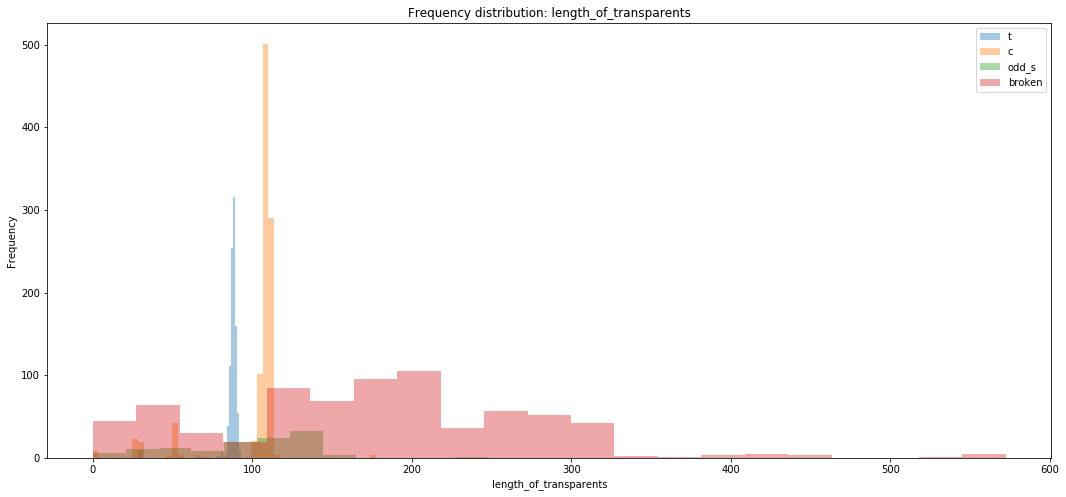

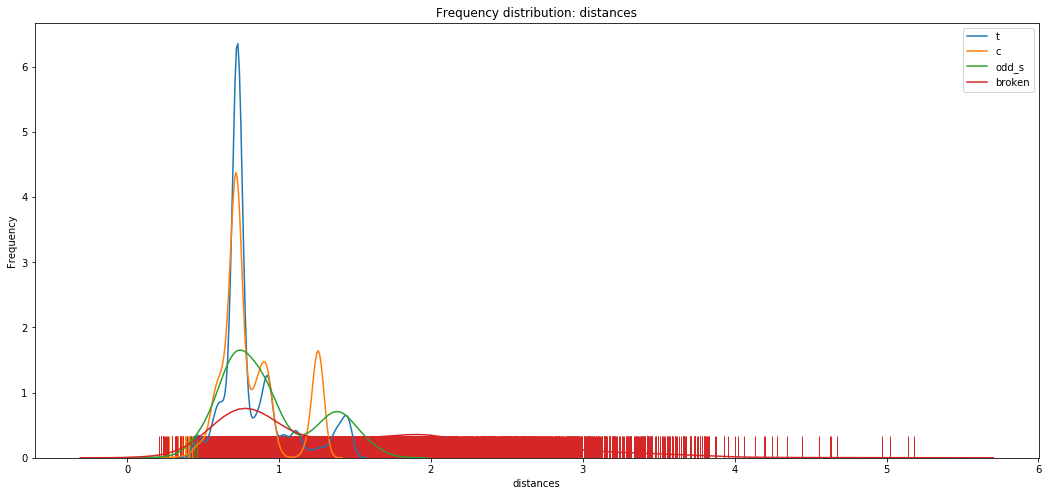

In [127]:

"""Correctly classified"""
# use area information from properties


propnames = ['num_blobs', 'num_connections', 'cons_of_max', 'length_of_transparents']
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [h[k] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    
    
    
print(len(klist[0]))
klist = []
for i in range(num_shape_cats):
    x = [d for lis in [h[4] for h in passes[i]] for d in lis]
    klist.append(x) #list of areas for every category
print(len(klist[0]))
print("distances averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
print("distances variances: " )
[print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: " +  'distances')
plt.xlabel( 'distances')
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = klist[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])